In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

## Data preparation

In [2]:
df = pd.read_csv("data/Blue and fin whales Southern California 2014-2015 - Fastloc GPS data.csv")

In [3]:
df = df[df['manually-marked-outlier'].isna()] # 19 outliers
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [39]:
whales = []
for id in df['individual-local-identifier'].unique():
    whales.append(df[df['individual-local-identifier']==id][['timestamp','location-lat','location-long']])

### Analyse timestamp

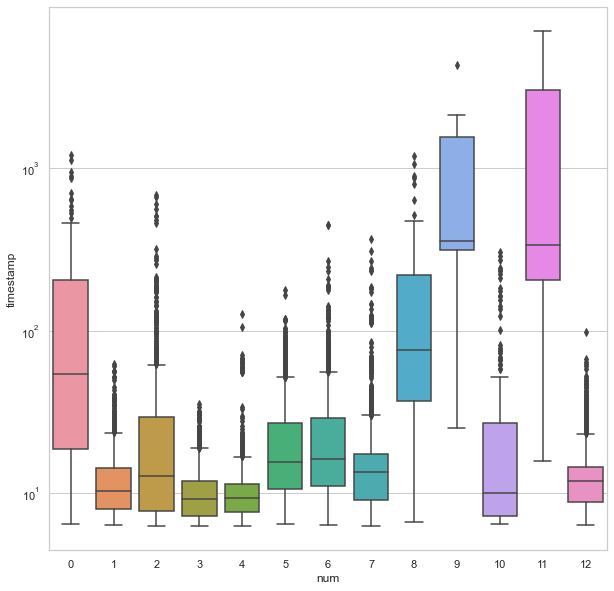

In [5]:
diffs = []
for i in range(len(whales)):
    diff = whales[i]['timestamp'].diff()/np.timedelta64(1, 'm')
    diff = diff.to_frame()
    diff['num'] = i
    diffs.append(diff)
diffs = pd.concat(diffs)
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
bx = sns.boxplot(data = diffs, x="num", y="timestamp")
bx.set_yscale("log")

In [57]:
interval = '20min'
datas = []
for whale in whales:
    data = whale.set_index('timestamp').resample(interval).mean().interpolate(method='polynomial',order=2)
    # data['timestamp'] = data['timestamp']/np.timedelta64(1, 's')
    data['daycos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('D').to_timestamp().timestamp())*2*np.pi/86400), axis=1)
    data['yearcos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('Y').to_timestamp().timestamp())*2*np.pi/31536000), axis=1)
    data[['location-lat','location-long']] = data[['location-lat','location-long']].diff()
    data = data.iloc[1:]
    datas.append(data)

In [55]:
def to_Xy(data, prepoints = 1):
    data = data.copy()
    for i in range(1,prepoints + 1):
        data[f'pre-location-lat{i}'] = data['location-lat'].shift(i)
        data[f'pre-location-long{i}'] = data['location-long'].shift(i)
    data = data.iloc[prepoints:]
    X = data.drop(['location-lat','location-long'], axis=1)
    y = data[['location-lat','location-long']]
    return X,y
            

In [210]:
prepoints = 10
i_split = int(len(data)*0.8)
X, y = to_Xy(datas[4], prepoints = prepoints)
X_train = X[:i_split]
X_test = X[i_split:]
y_train = y[:i_split]
ylat_train = y_train['location-lat']
ylong_train = y_train['location-long']
y_test = y[i_split:]
ylat_test = y_test['location-lat']
ylong_test = y_test['location-long']

In [200]:
def predict(clf_lat, clf_long, X, horizon = 1):
    prepoints = X.shape[1]//2 - 1
    X = X.copy()
    for p in range(horizon):
        X_pre = X.copy()
        ylat_next = clf_lat.predict(X)
        ylong_next = clf_long.predict(X)
        X = X[['daycos','yearcos']].copy()
        X['pre-location-lat1'] = ylat_next
        X['pre-location-long1'] = ylong_next
        for i in range(2,prepoints + 1):
            X[f'pre-location-lat{i}'] = X_pre[f'pre-location-lat{i-1}']
            X[f'pre-location-long{i}'] = X_pre[f'pre-location-long{i-1}']
            
    return ylat_next, ylong_next

## Prediction with Linear Regression

In [201]:
reg_lat = LinearRegression().fit(X_train,ylat_train)
reg_long = LinearRegression().fit(X_train,ylong_train)

In [202]:
print(reg_lat.coef_)
print(reg_long.coef_)

[ 5.95000329e-05 -2.30042755e-03  7.35422218e-01 -3.31394391e-03
 -1.32593678e-01 -3.47057845e-02  1.31275434e-01  3.72813305e-02
  2.94184441e-02  3.88092935e-04 -4.86726252e-03 -3.24465795e-02
  2.76236236e-03  2.67624427e-02  7.13712527e-03  4.21766502e-03
 -8.70826763e-03 -4.56213822e-02  3.23043521e-02  6.52753073e-03
  1.50811950e-02 -3.30089732e-03]
[-7.33106626e-05 -5.81186910e-03 -1.99791395e-01  7.12059563e-01
  1.42584445e-01 -1.06811674e-01 -3.20863743e-02  6.05883039e-02
  1.56455334e-02  5.68724552e-03  2.97712133e-02  3.64692216e-02
 -3.15703141e-02 -2.09004154e-02 -3.20828027e-02  3.20049513e-02
  5.95739339e-02 -1.04283253e-02 -5.11382639e-02  9.85012588e-03
 -3.75506132e-02  2.51481653e-03]


In [203]:
ylat_pred, ylong_pred = predict(reg_lat, reg_long, X_test, horizon=10)

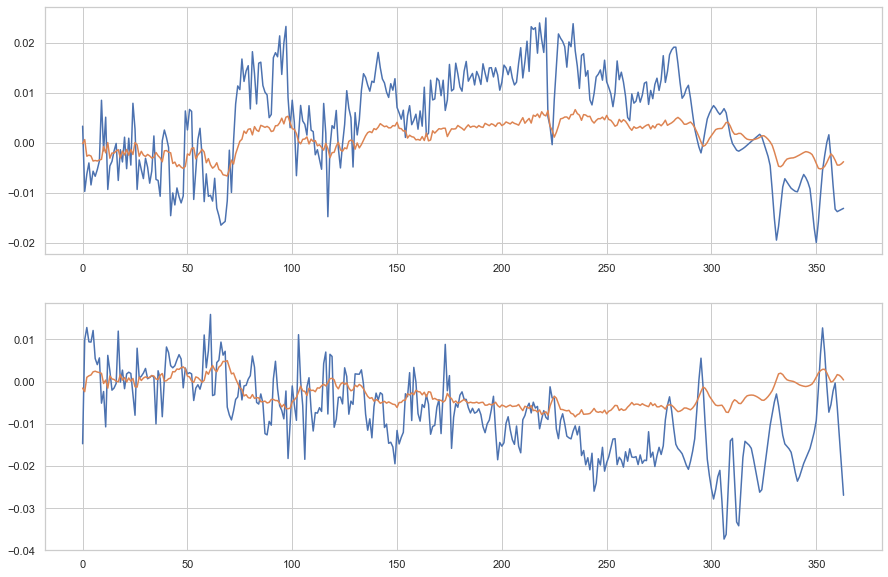

In [204]:
a=0
b=len(y_test)
points = list(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,ylat_test[a:b])
plt.plot(points,ylat_pred[a:b])
plt.subplot(2,1,2)
plt.plot(points,ylong_test[a:b])
plt.plot(points,ylong_pred[a:b])

In [205]:
mean_squared_error(ylat_pred,ylat_test)

6.987410064355739e-05

In [206]:
mean_squared_error(ylong_pred,ylong_test)

9.063068252535799e-05

## Prediction with AdaBoost

In [207]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [211]:
rng = 0
base = DecisionTreeRegressor(max_depth=10)
adareg_lat = AdaBoostRegressor(base,n_estimators=100,random_state = rng).fit(X_train,ylat_train)
adareg_long = AdaBoostRegressor(base,n_estimators=100,random_state = rng).fit(X_train,ylong_train)

In [212]:
ylat_pred, ylong_pred = predict(adareg_lat, adareg_long, X_test, horizon=10)

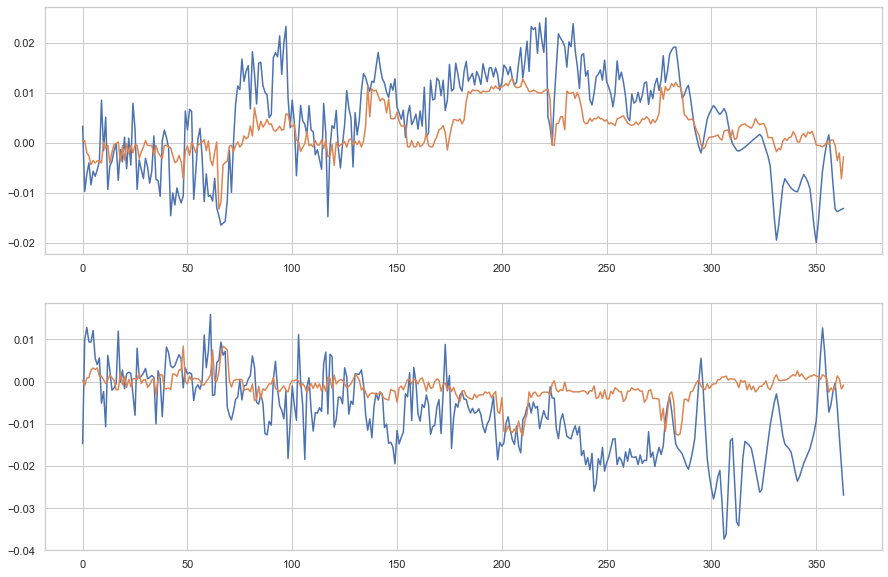

In [213]:
a=0
b=len(y_test)
points = list(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,ylat_test[a:b])
plt.plot(points,ylat_pred[a:b])
plt.subplot(2,1,2)
plt.plot(points,ylong_test[a:b])
plt.plot(points,ylong_pred[a:b])

In [214]:
mean_squared_error(ylat_pred,ylat_test)

5.7694937563617915e-05

In [215]:
mean_squared_error(ylong_pred,ylong_test)

0.00012488288974143495

## Prediction RNN

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
n = len(datas[7])
train_df = datas[7][0:int(n*0.8)]
val_df = datas[7][int(n*0.7):int(n*0.9)]
test_df = datas[7][int(n*0.8):]

print(len(train_df),len(val_df),len(test_df))

1666 416 417


In [70]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='location-lat', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')



In [76]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['location-lat'])


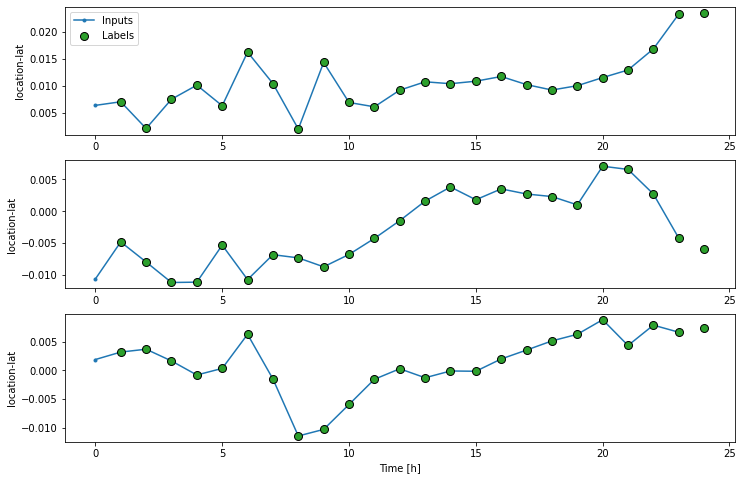

In [77]:
wide_window.plot()

In [78]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [79]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [80]:
history = compile_and_fit(lstm_model, wide_window)

print(lstm_model.evaluate(wide_window.val))
print(lstm_model.evaluate(wide_window.test, verbose=0))


Epoch 1/20
52/52 [==============================] - 9s 63ms/step - loss: 0.0051 - mean_absolute_error: 0.0489 - val_loss: 1.4975e-04 - val_mean_absolute_error: 0.0089
Epoch 2/20
52/52 [==============================] - 2s 27ms/step - loss: 1.7215e-04 - mean_absolute_error: 0.0101 - val_loss: 9.4977e-05 - val_mean_absolute_error: 0.0071
Epoch 3/20
52/52 [==============================] - 1s 25ms/step - loss: 1.0924e-04 - mean_absolute_error: 0.0081 - val_loss: 6.2107e-05 - val_mean_absolute_error: 0.0058
Epoch 4/20
52/52 [==============================] - 2s 26ms/step - loss: 7.4196e-05 - mean_absolute_error: 0.0066 - val_loss: 4.2112e-05 - val_mean_absolute_error: 0.0047
Epoch 5/20
52/52 [==============================] - 2s 26ms/step - loss: 5.2076e-05 - mean_absolute_error: 0.0055 - val_loss: 3.3521e-05 - val_mean_absolute_error: 0.0044
Epoch 6/20
52/52 [==============================] - 2s 27ms/step - loss: 3.7655e-05 - mean_absolute_error: 0.0047 - val_loss: 2.8362e-05 - val_mean_a

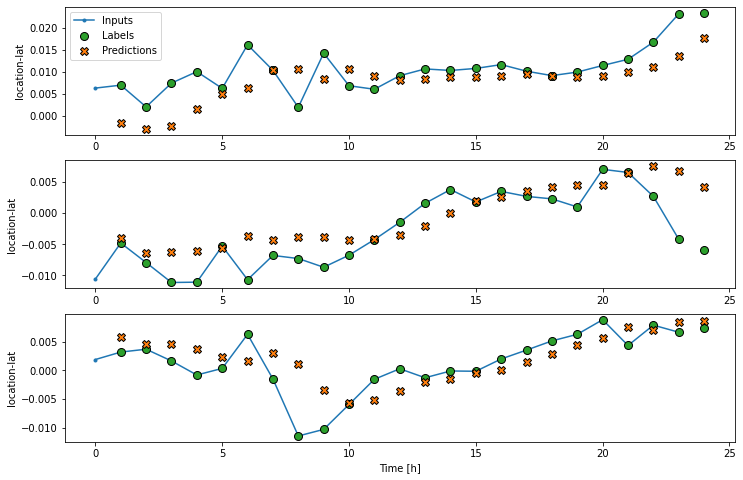

In [81]:
wide_window.plot(lstm_model)